In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# csv 호출 (제 노트북에 저장된 상태)
train = pd.DataFrame(pd.read_csv('/Users/leesangyup/Desktop/kaggle/train.csv'))
shops = pd.DataFrame(pd.read_csv('/Users/leesangyup/Desktop/kaggle/shops.csv'))
items = pd.DataFrame(pd.read_csv('/Users/leesangyup/Desktop/kaggle/items.csv'))
cats = pd.DataFrame(pd.read_csv('/Users/leesangyup/Desktop/kaggle/cats.csv'))
test = pd.DataFrame(pd.read_csv('/Users/leesangyup/Desktop/kaggle/test.csv'))

In [3]:
# # csv 호출 (kaggle에서)
# items=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
# shops=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")
# cats=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")
# train=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
# test=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")

In [4]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
# Shops

# train/test의 shop_id열에서 shop_name이 중복인 값의 shop_id 통일
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# shops의 shop_id열에서도 shop_name이 중복인 값의 shop_id 통일
shops.loc[shops.shop_id == 0, 'shop_id'] = 57
shops.loc[shops.shop_id == 0, 'shop_id'] = 57
shops.loc[shops.shop_id == 1, 'shop_id'] = 58
shops.loc[shops.shop_id == 1, 'shop_id'] = 58
shops.loc[shops.shop_id == 10, 'shop_id'] = 11
shops.loc[shops.shop_id == 10, 'shop_id'] = 11

shops.iloc[0,0] = 'Якутск Орджоникидзе, 56 фран	'
shops.iloc[1,0] = 'Якутск ТЦ "Центральный" фран'
shops.iloc[6,0] = 'Воронеж  (Плехановская, 13)'
shops.iloc[9,0] = ' Выездная Торговля '
shops.iloc[10,0] = 'Жуковский  ул.Чкалова39м'
shops.iloc[11,0] = 'Жуковский  ул.Чкалова39м²'
shops.iloc[12,0] = ' Интернет-магазин ЧС'
shops.iloc[20,0] = 'Москва  "Распродажа"'
shops.iloc[46,0] = 'СергиевПосад ТЦ "7Я"'
shops.iloc[55,0] = ' Цифровойсклад1С-Онлайн '
shops.iloc[57,0] = 'Якутск  Орджоникидзе'

shops['category'] = shops.shop_name.str.split(' ').map(lambda x: x[1])
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
                                              
                                              
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5 and cat != '':
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )
                                              
                                              
from sklearn.preprocessing import LabelEncoder
shops['shop_category'] = LabelEncoder().fit_transform(shops.category)
shops['shop_city'] = LabelEncoder().fit_transform(shops.city)
shops = shops[["shop_id", "shop_category", "shop_city"]]
                                              
                                              
# train, shops 병합
test_merge = pd.merge(train, shops, on = 'shop_id')
                                              
#items 및 cat
items = items.drop(['item_name'], axis=1)
                                              
#1. 문자열 분리
cats['split'] = cats['item_category_name'].str.split('-')
                                              
#2. [0]인 값만 사용, [1]의 unique()가 너무 많고, 최대 중복이 4여서 버림
                                              
cats['type'] = cats['split'].map(lambda x: x[0].strip())
                                              
#3. 카테고리 병합(PC와 모바일 게임도 게임으로 재분류)
cats.loc[cats['type']=='Игры PC','type'] = 'Игры'
cats.loc[cats['type']=='Игры MAC','type'] = 'Игры'
cats.loc[cats['type']=='Игры Android''type'] = 'Игры'

                                              
#4. 중복이 4보다 적은 값은 orters로 분류 -> label or onehot을 위해 최소화
cat_types =[]
for i in cats['type'].unique():
    if len(cats[cats['type'] == i]) >= 4:
        cat_types.append(i)
cats['type'] = cats['type'].apply(lambda x: x if (x in cat_types) else "orters")
                                              
#5. 라벨인코더
from sklearn.preprocessing import LabelEncoder
hot_model = LabelEncoder()
cats['type'] = hot_model.fit_transform(cats['type'])

                                              
#6. 병합할 데이터 셋
                                              
#병합시 Key(on) = item_category_id

cats_final = pd.DataFrame({'item_category_id':cats['item_category_id'],'type':cats['type']})
                                              
test_merge_items = pd.merge(items,cats_final, on='item_category_id')
                                              
# 전체 병합
test_merge = pd.merge(test_merge,test_merge_items, on='item_id')
                                              
# date열 제거
test_merge = test_merge.drop(['date'], axis=1)

In [6]:
train = test_merge

In [7]:
train = train[(train['item_cnt_day']>0) & (train['item_cnt_day']<1000)]

In [8]:
train

,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_category,shop_city,item_category_id,type
0,0,59,22154,999.0,1.0,4,28,37,5
1,0,25,22154,999.0,1.0,2,12,37,5
2,0,25,22154,999.0,1.0,2,12,37,5
3,0,25,22154,999.0,1.0,2,12,37,5
4,0,25,22154,999.0,1.0,2,12,37,5
...,...,...,...,...,...,...,...,...,...
3162144,33,20,21047,1899.0,1.0,0,12,61,8
3162145,33,20,21012,1899.0,1.0,0,12,61,8
3162146,33,20,20451,1699.0,1.0,0,12,72,8
3162147,33,20,20453,5399.0,1.0,0,12,72,8


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
group_city = train.groupby( ["shop_city", 'shop_id'] ).agg( {"item_cnt_day": ["sum"]} )
group_city.columns = ["shop_city_shop_id_cnt_sum"]
group_city.reset_index( inplace = True)
group_city.head()

,shop_city,shop_id,shop_city_shop_id_cnt_sum
0,0,9,15874.0
1,0,12,70821.0
2,0,55,63390.0
3,1,2,30706.0
4,2,3,28475.0


In [11]:
group_city_cnt = train.groupby("shop_city").agg( {"item_cnt_day": ["sum"]} )
group_city_cnt.columns = ["shop_city_cnt_sum"]
group_city_cnt.reset_index( inplace = True)
group_city_cnt.head()

,shop_city,shop_city_cnt_sum
0,0,150085.0
1,1,30706.0
2,2,28475.0
3,3,44069.0
4,4,42847.0


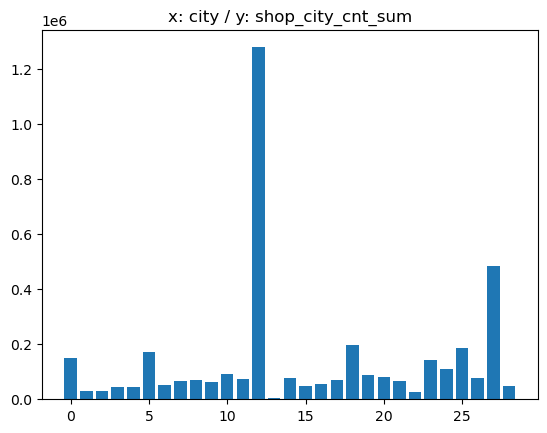

In [12]:
# 도시 별 item 총 판매량
plt.bar(group_city_cnt['shop_city'],group_city_cnt['shop_city_cnt_sum'])
plt.title('x: city / y: shop_city_cnt_sum')

plt.show()

In [13]:
list_city = group_city['shop_city'].unique().tolist()

In [14]:
num_list = []
for city in group_city["shop_city"].unique():
    num = len(group_city[group_city["shop_city"] == city])
    num_list.append(num)
    
num_sale_list = []
for city in list_city:
    num_sale = 0
    for i in group_city.index:
        if group_city.iloc[i,0] == city:
            num_sale += group_city.iloc[i,2]
    num_sale_list.append(num_sale)
    
list_city_one_shop= []
for i in range(len(num_list)):
    j = round(num_sale_list[i] / num_list[i] , 2)
    list_city_one_shop.append(j)

In [15]:
# 도시 별 shop 개수
num_list

[3,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 13,
 1,
 2,
 2,
 1,
 3,
 2,
 2,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 2,
 1]

In [16]:
# 도시 별 팔린 item 가격 총합
num_sale_list

[150085.0,
 30706.0,
 28475.0,
 44069.0,
 42847.0,
 171518.0,
 50190.0,
 66277.0,
 71331.0,
 61772.0,
 91539.0,
 73668.0,
 1278332.0,
 5504.0,
 75621.0,
 46743.0,
 54049.0,
 71020.0,
 196018.0,
 87106.0,
 79092.0,
 67833.0,
 24998.0,
 142268.0,
 111708.0,
 186149.0,
 78276.0,
 482696.0,
 49131.0]

In [17]:
# 도시 별 팔린 item 가격 총합 / 도시 별 shop 개수
list_city_one_shop

[50028.33,
 30706.0,
 28475.0,
 44069.0,
 42847.0,
 57172.67,
 50190.0,
 33138.5,
 71331.0,
 61772.0,
 45769.5,
 73668.0,
 98333.23,
 5504.0,
 37810.5,
 23371.5,
 54049.0,
 23673.33,
 98009.0,
 43553.0,
 79092.0,
 67833.0,
 24998.0,
 47422.67,
 55854.0,
 186149.0,
 78276.0,
 241348.0,
 49131.0]

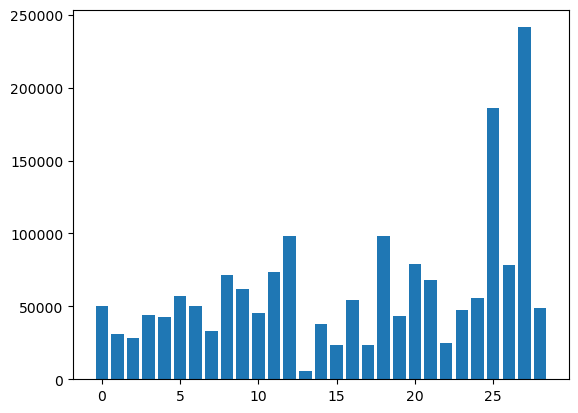

In [18]:
# 도시 별 shop 1개의 item 총 판매량
plt.bar(list_city,list_city_one_shop)

plt.show()

In [19]:
group_city_price = train.groupby( ["shop_city"] ).agg( {"item_price": ["mean"]} )
group_city_price.columns = ["shop_city_price_mean"]
group_city_price.reset_index( inplace = True)

group_city_price.head()

,shop_city,shop_city_price_mean
0,0,1041.749555
1,1,1349.202548
2,2,1033.090115
3,3,922.435604
4,4,869.640755


In [20]:

group_city_price = train.groupby( ["shop_city"] ).agg( {"item_cnt_day": ["sum"], "item_price": ["mean"]} )
group_city_price.columns = ["shop_city_cnt_sum", "shop_city_price_mean"]
group_city_price.reset_index( inplace = True)

group_city_price.head()

,shop_city,shop_city_cnt_sum,shop_city_price_mean
0,0,150085.0,1041.749555
1,1,30706.0,1349.202548
2,2,28475.0,1033.090115
3,3,44069.0,922.435604
4,4,42847.0,869.640755


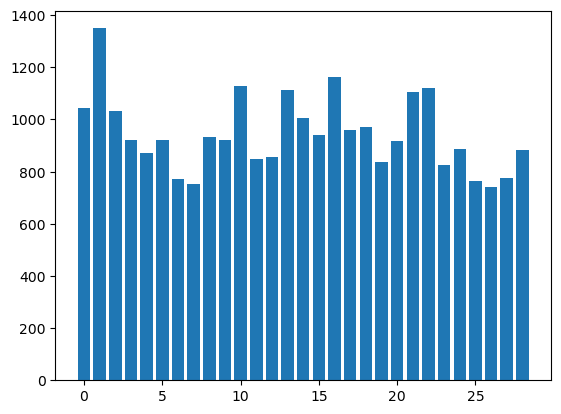

In [21]:
# 도시 별 판린 item 가격 평균
plt.bar(group_city_price['shop_city'],group_city_price['shop_city_price_mean'])

plt.show()

In [22]:
group_shop_id = train.groupby( ["shop_id"] ).agg( {"item_cnt_day": ["sum"], "item_price": ["mean"]} )
group_shop_id.columns = ["shop_id_cnt_sum", "shop_id_price_maen"]
group_shop_id.reset_index( inplace = True)
group_shop_id.head()

,shop_id,shop_id_cnt_sum,shop_id_price_maen
0,2,30706.0,1349.202548
1,3,28475.0,1033.090115
2,4,44069.0,922.435604
3,5,42847.0,869.640755
4,6,100757.0,900.037157


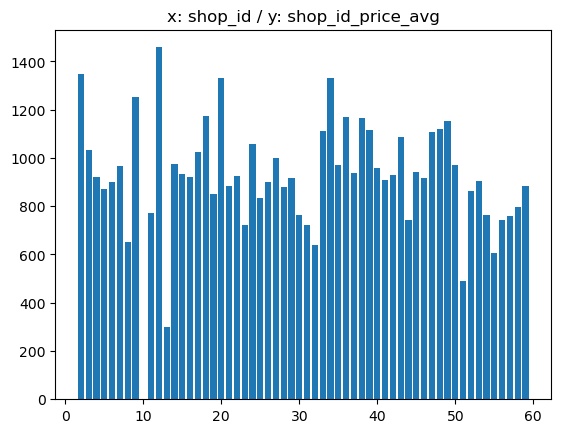

In [23]:
# shop_id 별 판매 item 가격 평균
plt.bar(group_shop_id['shop_id'],group_shop_id['shop_id_price_maen'])
plt.title('x: shop_id / y: shop_id_price_avg')

plt.show()

In [24]:
group_shop_id = train.groupby( ["shop_id"] ).agg( {"item_cnt_day": ["sum"], "item_price": ["mean"]} )
group_shop_id.columns = ["shop_id_cnt_sum", "shop_id_price_mean"]
group_shop_id.reset_index( inplace = True)
group_shop_id.head()

,shop_id,shop_id_cnt_sum,shop_id_price_mean
0,2,30706.0,1349.202548
1,3,28475.0,1033.090115
2,4,44069.0,922.435604
3,5,42847.0,869.640755
4,6,100757.0,900.037157


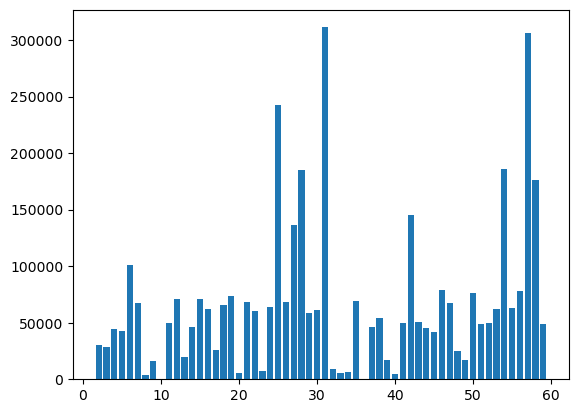

In [25]:
# shop_id별 총 판매량
plt.bar(group_shop_id['shop_id'],group_shop_id['shop_id_cnt_sum'])
plt.show()

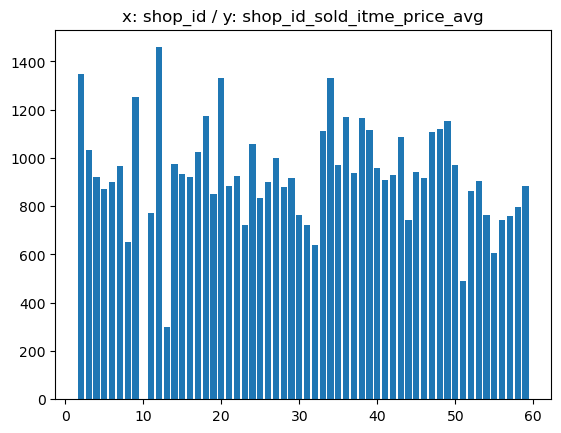

In [26]:
plt.bar(group_shop_id['shop_id'],group_shop_id['shop_id_price_mean'])
plt.title('x: shop_id / y: shop_id_sold_itme_price_avg')
plt.show()

In [27]:
group_category = train.groupby( ["shop_category"] ).agg( {"item_cnt_day": ["sum"], "item_price": ["mean"]} )
group_category.columns = ["shop_category_cnt_sum", "shop_category_price_mean"]
group_category.reset_index( inplace = True)

group_category.head()

,shop_category,shop_category_cnt_sum,shop_category_price_mean
0,0,742182.0,846.866817
1,1,317616.0,963.683577
2,2,297826.0,880.542798
3,3,449132.0,951.441409
4,4,2112265.0,864.578125


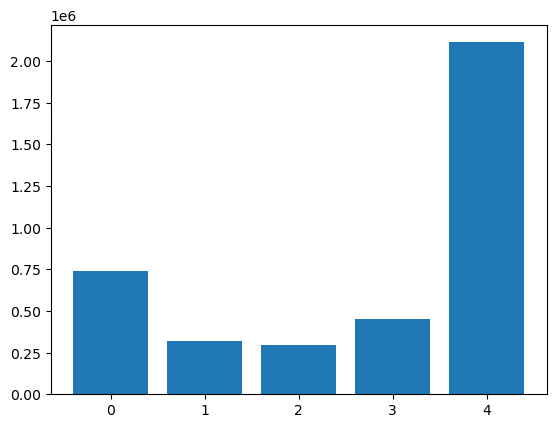

In [28]:
plt.bar(group_category['shop_category'],group_category['shop_category_cnt_sum'])
plt.show()

In [29]:
# list_shop_category_price= []
# for i in group_category.index:
#     j = round(group_category.iloc[i,2] / group_category.iloc[i,1] , 2)
#     list_shop_category_price.append(j)

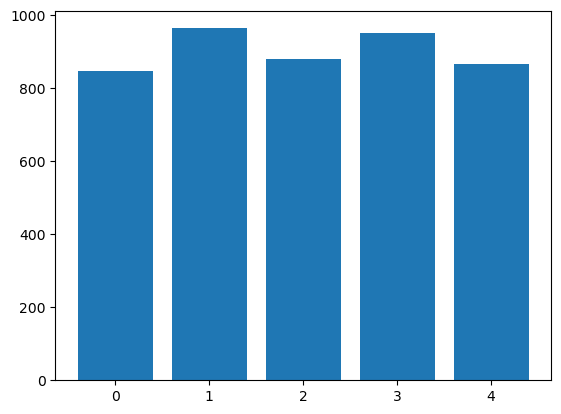

In [30]:
plt.bar(group_category['shop_category'],group_category['shop_category_price_mean'])
plt.show()

Text(0.5, 1.0, 'x : shop_category / y: sold item price average')

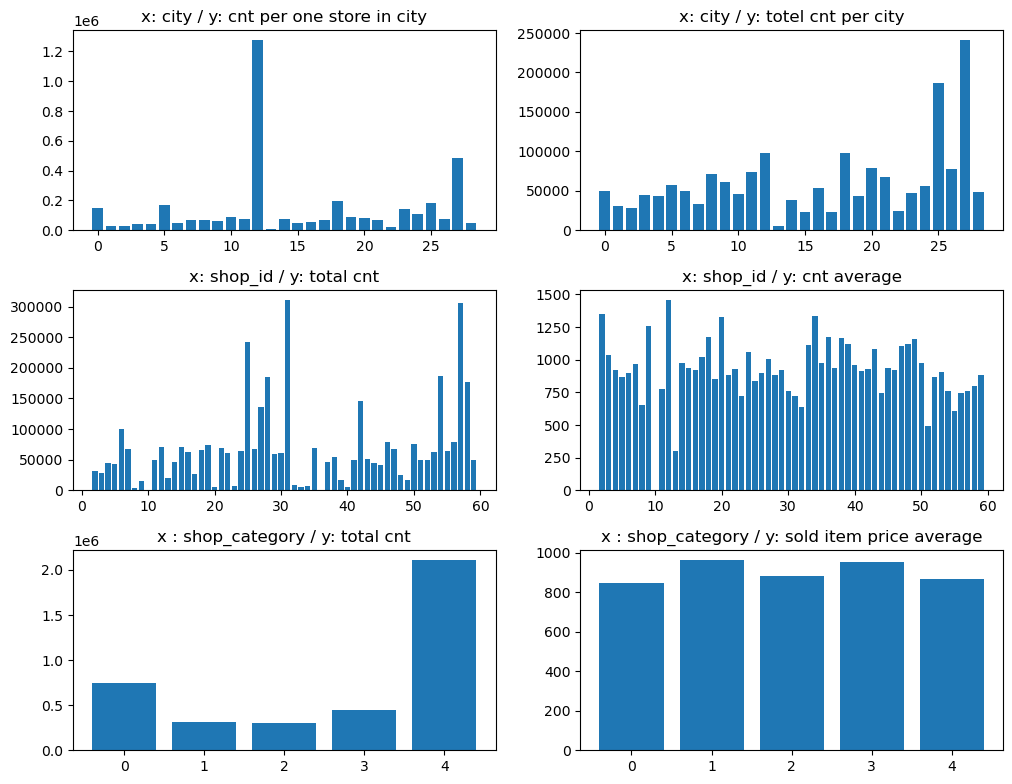

In [31]:
plt.rc('figure', figsize=(12, 8))
fig = plt.figure()
plt.subplots_adjust(left=0.125, bottom=0.3, right=0.9, top=1.2, wspace=0.2, hspace=0.3)

ax_1 = fig.add_subplot(3,2,1)
ax_2 = fig.add_subplot(3,2,2)
ax_3 = fig.add_subplot(3,2,3)
ax_4 = fig.add_subplot(3,2,4)
ax_5 = fig.add_subplot(3,2,5)
ax_6 = fig.add_subplot(3,2,6)

ax_1.bar(group_city_cnt['shop_city'],group_city_cnt['shop_city_cnt_sum'])
ax_1.set_title('x: city / y: cnt per one store in city')

ax_2.bar(list_city,list_city_one_shop)
ax_2.set_title('x: city / y: totel cnt per city')

ax_3.bar(group_shop_id['shop_id'],group_shop_id['shop_id_cnt_sum'])
ax_3.set_title('x: shop_id / y: total cnt')

ax_4.bar(group_shop_id['shop_id'],group_shop_id['shop_id_price_mean'])
ax_4.set_title('x: shop_id / y: cnt average')


ax_5.bar(group_category['shop_category'],group_category['shop_category_cnt_sum'])
ax_5.set_title('x : shop_category / y: total cnt')

ax_6.bar(group_category['shop_category'],group_category['shop_category_price_mean'])
ax_6.set_title('x : shop_category / y: sold item price average')


In [32]:
group_city = train.groupby( ['date_block_num',"shop_city"] ).agg( {"item_cnt_day": ["sum"]} )
group_city.columns = ["shop_city_cnt_sum"]
group_city.reset_index( inplace = True)
group_city

,date_block_num,shop_city,shop_city_cnt_sum
0,0,0,881.0
1,0,1,1151.0
2,0,2,767.0
3,0,3,2117.0
4,0,5,7660.0
...,...,...,...
933,33,23,1599.0
934,33,24,1917.0
935,33,26,1267.0
936,33,27,7534.0


<AxesSubplot:xlabel='date_block_num', ylabel='shop_city_cnt_sum'>

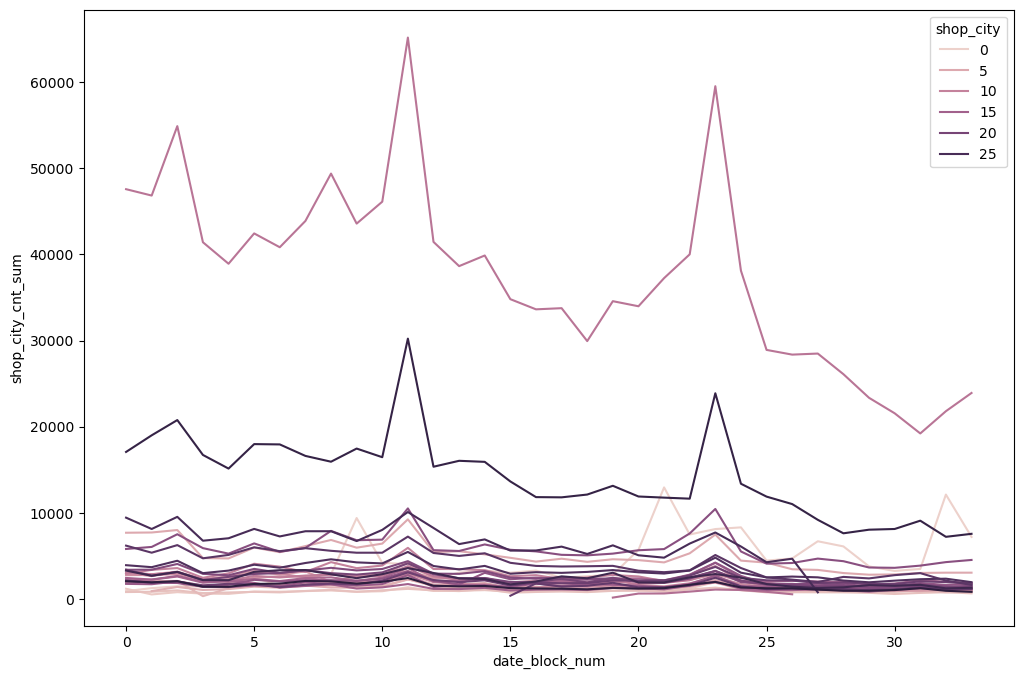

In [33]:
# 월별 city별 매출
sns.lineplot(data = group_city, x = 'date_block_num', y = 'shop_city_cnt_sum', hue = 'shop_city')

In [34]:
group_shop_id = train.groupby( ['date_block_num',"shop_id"] ).agg( {"item_cnt_day": ["sum"]} )
group_shop_id.columns = ["shop_id_cnt_sum"]
group_shop_id.reset_index( inplace = True)
group_shop_id

,date_block_num,shop_id,shop_id_cnt_sum
0,0,2,1151.0
1,0,3,767.0
2,0,4,2117.0
3,0,6,3699.0
4,0,7,2498.0
...,...,...,...
1577,33,55,1972.0
1578,33,56,1267.0
1579,33,57,4638.0
1580,33,58,2896.0


<AxesSubplot:xlabel='date_block_num', ylabel='shop_id_cnt_sum'>

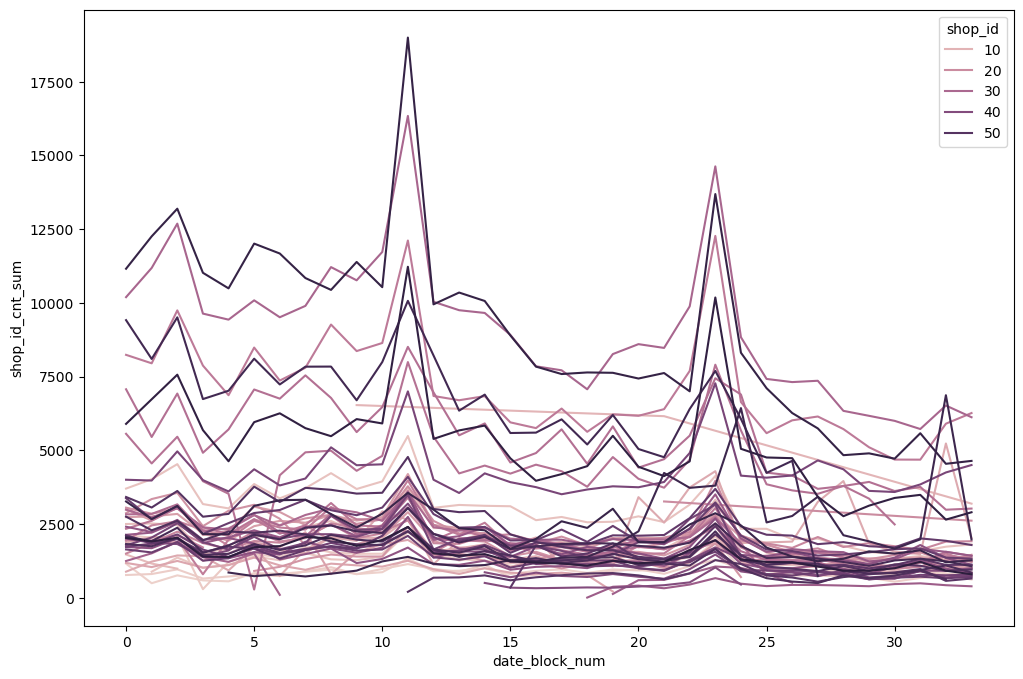

In [35]:
# 월별 shop_id별 매출
sns.lineplot(data = group_shop_id, x = 'date_block_num', y = 'shop_id_cnt_sum', hue = 'shop_id')

In [36]:
group_shop_category = train.groupby( ['date_block_num',"shop_category"] ).agg( {"item_cnt_day": ["sum"]} )
group_shop_category.columns = ["shop_id_shop_category_cnt"]
group_shop_category.reset_index( inplace = True)
group_shop_category

,date_block_num,shop_category,shop_id_shop_category_cnt
0,0,0,21030.0
1,0,1,11317.0
2,0,2,9002.0
3,0,3,14208.0
4,0,4,85753.0
...,...,...,...
165,33,0,20335.0
166,33,1,6578.0
167,33,2,7875.0
168,33,3,10477.0


<AxesSubplot:xlabel='date_block_num', ylabel='shop_id_shop_category_cnt'>

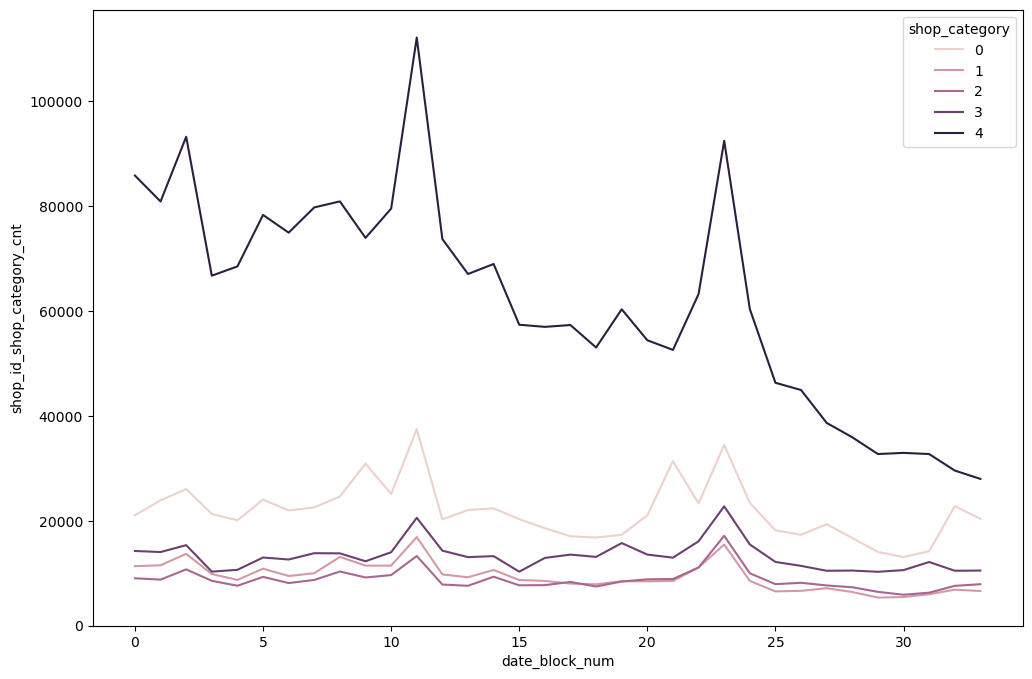

In [37]:
# 월 별 shop_category 별 매출
sns.lineplot(data = group_shop_category, x = 'date_block_num', y = 'shop_id_shop_category_cnt', hue = 'shop_category')